# Building Training Sets with Weak Supervision
In this tutorial, we'll build a `Pain-At` relation training set using weakly superivsed methods. This notebook covers: 
- Loading pre-processed documents
- Generating relational candidates 
- Applying labeling functions
- Training a Snorkel Label Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0,'../../ehr-rwe/')

import glob
import collections
import numpy as np
import pandas as pd


## 1. Load MIMIC-III Documents
We assume documents have already been preprocessed and dumped into JSON format. See `preprocessing/README.md` for details.

You will need access to MIMIC-III data to run this notebook. See https://mimic.physionet.org/gettingstarted/access/


In [5]:
from rwe import dataloader

inputdir = '/Users/fries/Desktop/clef-rwe/'
#inputdir = '/Users/fries/Desktop/ehr-notes/'

corpus = dataloader(glob.glob(f'{inputdir}/*.json'))

print(f'Loaded {len(corpus)} documents')


Loaded 299 documents


## 2. Generate Candidates

This is an example pipeline for generating `Pain-At` relation candidates. For simplicity's sake, we use a dictionary-based method to tag our initial `Anatomy` and `Pain` entities. 

### Timing Benchmarks 

- 50,000 MIMIC-III documents
- 4 core MacBook Pro 2.5Ghz mid-2015

| N Documents   | N Cores | Time |
|---------------|---------|----------------|
| 299           | 4       | 17 seconds |
| 10,000        | 4       | 4 minutes  |


In [6]:
import json

splits = json.load(open('/Users/fries/Desktop/clef-ehr-dataset/splits.json','r'))
for name in splits:
    print(name, len(splits[name]))


train 166
dev 133
test 133


In [7]:
from rwe.utils import load_dict
from rwe.labelers.taggers import (
    ResetTags, RelationTagger, 
    DictionaryTagger, NegExTagger, HypotheticalTagger, 
    SectionHeaderTagger, ParentSectionTagger
)

dict_pain = load_dict('../data/dicts/pain/pain.txt')
dict_anat = load_dict('../data/dicts/anatomy/anat.bz2')

pipeline = {
    # clear any previous runs
    "reset"   : ResetTags(),
    
    # concepts
    "pain"     : DictionaryTagger({'pain': dict_pain}),
    "anatomy"  : DictionaryTagger({'anatomy': dict_anat}),
    "sections" : SectionHeaderTagger(),
    
    # attributes / primitives
    "negation"     : NegExTagger(targets=['pain'], data_root="../data/dicts/negex/"),
    "hypothetical" : HypotheticalTagger(targets=['pain']),
    "headers"      : ParentSectionTagger(targets=['pain']),
    
    # relations
    "pain-at" : RelationTagger('pain-at', ('pain', 'anatomy'))
}


In [8]:
%%time
from rwe.labelers import TaggerPipelineServer

tagger = TaggerPipelineServer(num_workers=4)
documents = tagger.apply(pipeline, [corpus])


auto block size=75
Partitioned into 4 blocks, [74 75] sizes
CPU times: user 464 ms, sys: 125 ms, total: 588 ms
Wall time: 15.3 s


In [9]:
from rwe.utils import build_candidate_set, load_gold

fpath = "../data/annotations/mimic.gold.final.tsv"
gold = load_gold(fpath, documents[0], ('part-at', ('pain','anatomy')))

Xs = build_candidate_set(documents[0], "pain-at")
Ys = [gold[x] if x in gold else 0 for x in Xs]
Ys = [y if y == 1 else 2 for y in Ys]

print("Class Balance")
print(f'Positive: {Ys.count(1)} ({Ys.count(1)/len(Ys)*100:2.1f})%')
print(f'Negative: {Ys.count(2)} ({Ys.count(2)/len(Ys)*100:2.1f})%')

Class Balance
Positive: 138 (27.6)%
Negative: 362 (72.4)%


## 3. Apply Labeling Functions

In [11]:
import re
from rwe.labelers.taggers import get_left_span, get_right_span, get_between_span

def dict_matches(span, dictionary):
    matches = []
    toks = span.get_attrib_tokens('words')
    for i in range(len(toks)):
        for j in range(i+1, len(toks)):
            term = ' '.join(toks[i:j]).lower()
            if term in dictionary:
                matches.append(term)
    return matches

ABSTAIN  = 0
NEGATIVE = 2
POSITIVE = 1

neg_rgx = re.compile(
    r'''\b(insensitivity|paresthesias|paresthesia|sensitivity|tenderness|discomfort|heaviness|sensitive|itchiness|tightness|throbbing|numbness|tingling|cramping|coldness|soreness|painful|hurting|itching|burning|tender|buring|aching|hurts|aches|pains|hurt|pain|ache|achy|numb)\b''',
    re.I
)

def LF_is_negated(x):
    return NEGATIVE if 'negated' in x.pain.props else ABSTAIN

def LF_is_hypothetical(x):
    return NEGATIVE if 'hypothetical' in x.pain.props else ABSTAIN

def LF_section_headers(x):
    sections = {
        'past medical history': NEGATIVE,
        'chief complaint': POSITIVE,
        'discharge instructions': NEGATIVE,
        'discharge condition': NEGATIVE
    }
    header = x.pain.props['section'].text.lower() if x.pain.props['section'] else None
    return ABSTAIN if header not in sections else sections[header]

#def LF_contiguous(x):
#    return POSITIVE if not get_between_span(x.pain, x.anatomy) else ABSTAIN

def LF_contiguous(x):
    v = not get_between_span(x.pain, x.anatomy)
    v &= not 'negated' in x.pain.props
    v &= not 'hypothetical' in x.pain.props
    return POSITIVE if v else ABSTAIN

def LF_distant_args(x):
    span = get_between_span(x.pain, x.anatomy)
    n_toks = len(span.get_attrib_tokens('words')) if span else 0
    return NEGATIVE if n_toks > 10 else ABSTAIN
    
def LF_between_terms(x):
    """Reject if some key terms occur between arguments."""
    span = get_between_span(x.pain, x.anatomy)
    if not span:
        return ABSTAIN
    # negation term      
    flag = neg_rgx.search(span.text) is not None
    # anatomical term 
    flag |= len(dict_matches(span, dict_anat)) > 0
    return NEGATIVE if flag else ABSTAIN

def LF_complains_of(x):
    rgx = re.compile(r'''\b(complain(s*|ing*) of)\b''', re.I)
    is_negated = 'negated' in x.pain.props
    is_complains_of = rgx.search(get_left_span(x.pain).text, re.I) is not None
    return POSITIVE if not is_negated and is_complains_of else ABSTAIN
    

lfs = [
    LF_is_negated,
    LF_is_hypothetical,
    LF_section_headers,
    LF_contiguous,
    LF_distant_args,
    LF_between_terms,
    LF_complains_of
]


In [12]:

            
            

# # for x in Xs:
# #     v = LF_between_terms(x)
# #     print(v)

# x = Xs[10]
# span = get_between_span(x.pain, x.anatomy)




In [13]:
%%time
from rwe.labelers import LabelingServer

labeler = LabelingServer(num_workers=4)
Ls = labeler.apply(lfs, [Xs])


CPU times: user 163 ms, sys: 43.7 ms, total: 207 ms
Wall time: 433 ms


In [14]:
from rwe.analysis import lf_summary

lf_summary(Ls[0], Y=Ys, lf_names=[lf.__name__ for lf in lfs])

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF_is_negated,0,2,0.166,0.054,0.000,82,1,0.987952
LF_is_hypothetical,1,2,0.038,0.030,0.000,19,0,1.000000
LF_section_headers,2,"[1, 2]",0.218,0.180,0.070,100,9,0.917431
LF_contiguous,3,1,0.348,0.112,0.068,108,66,0.620690
LF_distant_args,4,2,0.224,0.188,0.002,110,2,0.982143
LF_between_terms,5,2,0.256,0.210,0.002,124,4,0.968750
LF_complains_of,6,1,0.018,0.016,0.002,6,3,0.666667


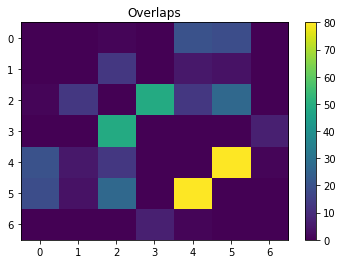

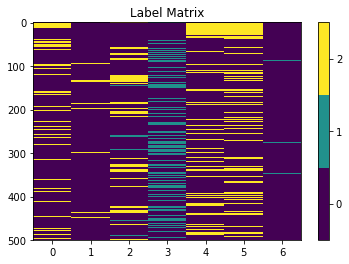

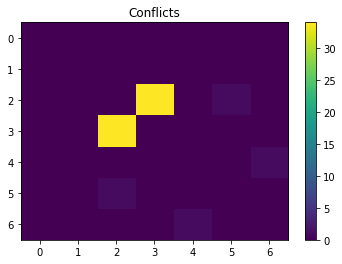

In [15]:
from rwe.visualization.analysis import view_conflicts, view_label_matrix, view_overlaps

view_overlaps(Ls[0], normalize=False)
view_label_matrix(Ls[0])
view_conflicts(Ls[0], normalize=False)

## 4. Train Snorkel Label Model 

In [16]:
# convert sparse matrix to new Snorkel format

def convert_label_matrix(L):
    L = L.toarray().copy()
    L[L == 0] = -1
    L[L == 2] = 0
    return L


Ls_hat = [
    convert_label_matrix(Ls[0])
]

Ys_hat = [
    np.array([0 if y == 2 else 1 for y in Ys])
]


In [17]:
from snorkel.labeling import LabelModel

lr = 0.01
l2 = 0.001
prec_init = 0.9

label_model = LabelModel(cardinality=2, device='cpu', verbose=True)
label_model.fit(L_train=Ls_hat[0], 
                n_epochs=1000, 
                lr=lr,
                l2=l2,
                prec_init=prec_init,
                optimizer='adam',
                log_freq=100)

metrics = ['accuracy', 'precision', 'recall', 'f1']
label_model.score(L=Ls_hat[0], Y=Ys_hat[0], metrics=metrics)


{'accuracy': 0.7825059101654847,
 'precision': 0.5567010309278351,
 'recall': 0.9473684210526315,
 'f1': 0.7012987012987012}